# Roadshow CreditCard Default Classifcation Demo

## CRISP-DM Data Science Process

<img src='CRISP-DM_Process_Diagram.png' width="600">

# CRISP-DM -- Business Understanding - 20% Time
* The business problem of the creditcard company is that ~3% of creditcard owners are not able to pay their creditcard debt loosing an average of 835€ per creditcard owner.
* If we can predict the probability of creditcard default, we can take appropiate measures to limit the financial damage.

# CRISP-DM -- Data Understanding & Preparation - 40% Time
* Manually Intensive process to explore and prepare data

## Python Library Imports

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scikitplot as skplt
from scipy.stats import norm
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.mixture import GaussianMixture, GMM
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.optimize import curve_fit
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score

import sklearn.linear_model as skl_lm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn import neighbors
from IPython.display import display_html

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-ticks')

## Load CreditCard Default Data

In [2]:
cc_data = pd.read_csv('Default.csv', index_col=0, sep=';')

In [3]:
cc_data.shape

(10000, 4)

In [4]:
cc_data.head()

,default,student,balance,income
1,No,No,"729,5264952","44361,62507"
2,No,Yes,"817,1804066","12106,1347"
3,No,No,"1073,549164","31767,13895"
4,No,No,"529,2506047","35704,49394"
5,No,No,"785,6558829","38463,49588"


### Transform Data

In [5]:
cc_data.dtypes

default    object
student    object
balance    object
income     object
dtype: object

In [6]:
#Convert to correct types
cc_data['default'] = cc_data['default'].astype('category')
cc_data['student'] = cc_data['student'].astype('category')
cc_data['balance'] = cc_data['balance'].apply(lambda str_flt : float(str_flt.replace(',','.'))).astype('float')
cc_data['income'] = cc_data['income'].apply(lambda str_flt : float(str_flt.replace(',','.'))).astype('float')
cc_data['default_encoded'] = cc_data.default.factorize()[0]
cc_data['student_encoded'] = cc_data.student.factorize()[0]

#Scales variables for Machine learning models
scaler = MinMaxScaler()
scaler.fit(cc_data[['balance']])
cc_data['balance_scaled'] = scaler.transform(cc_data[['balance']])
scaler.fit(cc_data[['income']])
cc_data['income_scaled'] = scaler.transform(cc_data[['income']])
cc_data = cc_data.sort_index(axis=1)

cc_data.dtypes

balance             float64
balance_scaled      float64
default            category
default_encoded       int64
income              float64
income_scaled       float64
student            category
student_encoded       int64
dtype: object

In [7]:
cc_data.head()

,balance,balance_scaled,default,default_encoded,income,income_scaled,student,student_encoded
1,729.526495,0.274845,No,0,44361.62507,0.598905,No,0
2,817.180407,0.307868,No,0,12106.13470,0.155727,Yes,1
3,1073.549164,0.404453,No,0,31767.13895,0.425862,No,0
4,529.250605,0.199392,No,0,35704.49394,0.479959,No,0
5,785.655883,0.295991,No,0,38463.49588,0.517867,No,0


### Check Duplicates

In [8]:
dups = cc_data.duplicated(subset=['default','student','balance','income']).sum()
print('Aantal duplicaten: {}'.format(dups))

Aantal duplicaten: 0


### Check NaNs

In [9]:
cc_data.isnull().sum()

balance            0
balance_scaled     0
default            0
default_encoded    0
income             0
income_scaled      0
student            0
student_encoded    0
dtype: int64

## Explore CreditCard Default Data

### Descriptive Statistics

In [10]:
cc_data.loc[:,['balance', 'balance_scaled', 'income', 'income_scaled']].describe()

,balance,balance_scaled,income,income_scaled
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,835.374886,0.314722,33516.981876,0.449904
std,483.714985,0.182237,13336.639563,0.183240
min,0.000000,0.000000,771.967729,0.000000
25%,481.731105,0.181489,21340.462905,0.282603
50%,823.636973,0.310300,34552.644800,0.464133
75%,1166.308387,0.439400,43807.729275,0.591295
max,2654.322576,1.000000,73554.233500,1.000000


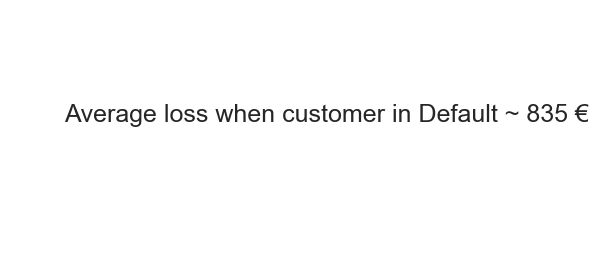

In [11]:
t_ax = plt.text(0.1,0.5, 'Average loss when customer in Default ~ {} €'.format(835),size=25)
t_ax = plt.axis('off')

### Explore Default

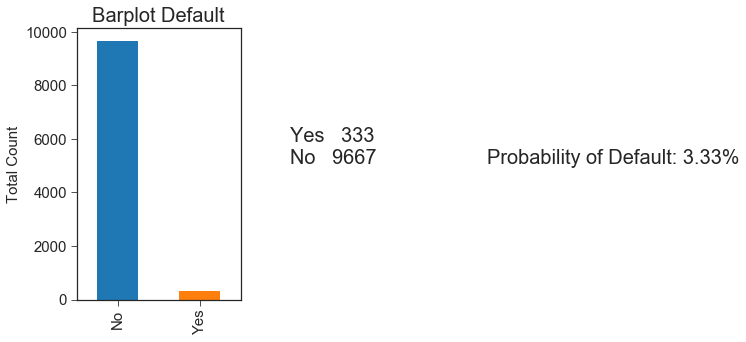

In [12]:
fig, axes = plt.subplots(1,3,figsize=(10,5))
d_ax = cc_data.default.value_counts().plot.bar(fontsize=15, title='Barplot Default', ax=axes[0])
axes[0].title.set_size(20)
axes[0].set_ylabel('Total Count', size=15)

t_tbl = cc_data.default.value_counts().to_frame().sort_index(ascending=False)
t_ax = axes[1].text(0.1,0.5,t_tbl.to_string(header=False),size=20)
t_ax = axes[1].axis('off')
t_ax = axes[2].text(0.1,0.5, 'Probability of Default: {}%'.format(round(333/(333+9667)*100,2)),size=20)
t_ax = axes[2].axis('off')

#### Explore Student

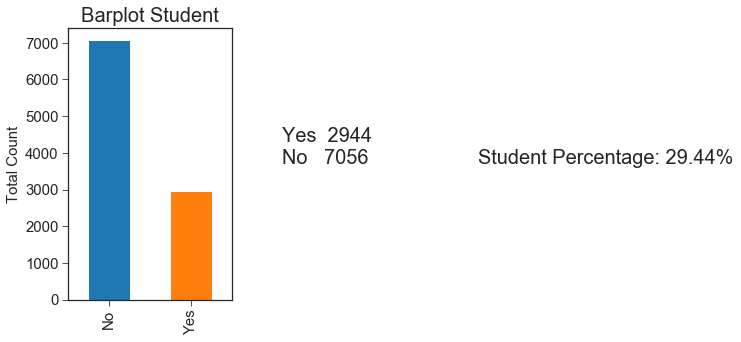

In [13]:
fig, axes = plt.subplots(1,3,figsize=(10,5))
d_ax = cc_data.student.value_counts().plot.bar(fontsize=15, title='Barplot Student', ax=axes[0])
axes[0].title.set_size(20)
axes[0].set_ylabel('Total Count', size=15)

t_tbl = cc_data.student.value_counts().to_frame().sort_index(ascending=False)
t_ax = axes[1].text(0.1,0.5,t_tbl.to_string(header=False),size=20)
t_ax = axes[1].axis('off')
t_ax = axes[2].text(0.1,0.5, 'Student Percentage: {}%'.format(round(2944/(2944+7056)*100,2)),size=20)
t_ax = axes[2].axis('off')

#### Explore Balance

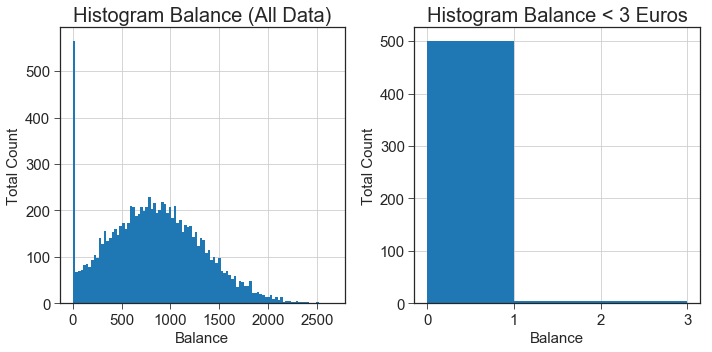

In [14]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax0 = cc_data.balance.hist(bins=100, ax=axes[0])
ax0.set_title('Histogram Balance (All Data)')
ax0.title.set_size(20)
ax0.tick_params(labelsize=15)
axes[0].set_ylabel('Total Count', size=15)
axes[0].set_xlabel('Balance', size=15)
ax1 = cc_data.loc[cc_data.balance < 3, :].balance.hist(bins=3, ax=axes[1])
ax1.set_title('Histogram Balance < 3 Euros')
ax1.title.set_size(20)
ax1.tick_params(labelsize=15)
axes[1].set_ylabel('Total Count', size=15)
axes[1].set_xlabel('Balance', size=15)
plt.tight_layout()

In [15]:
print('\t Absolut Aantal Individuen < 1 euro op balance: {}\n'.format(cc_data.loc[cc_data.balance < 1, :].shape[0])
      ,'\t Percentage Aantal Individuen < 1 euro op balance: {}%'.format(cc_data.loc[cc_data.balance < 1, :].shape[0] / cc_data.shape[0] * 100))

	 Absolut Aantal Individuen < 1 euro op balance: 501
 	 Percentage Aantal Individuen < 1 euro op balance: 5.01%


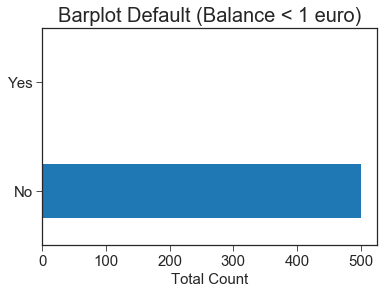

In [16]:
t_ax = cc_data.loc[cc_data.balance < 1, :].default.value_counts().plot.barh(fontsize=15, title='Barplot Default (Balance < 1 euro)')
t_ax.title.set_size(20)
t = t_ax.set_xlabel('Total Count', size=15)

In [17]:
#Create variable less than 1 < euro (binary categorical)
cc_data['balance_lt_1_eur'] = np.NaN
cc_data.loc[cc_data.balance < 1,'balance_lt_1_eur'] = 1
cc_data.loc[cc_data.balance > 1,'balance_lt_1_eur'] = 0
cc_data['balance_lt_1_eur'] = cc_data['balance_lt_1_eur'].astype('int')
cc_data = cc_data.sort_index(axis=1)
cc_data.head()

,balance,balance_lt_1_eur,balance_scaled,default,default_encoded,income,income_scaled,student,student_encoded
1,729.526495,0,0.274845,No,0,44361.62507,0.598905,No,0
2,817.180407,0,0.307868,No,0,12106.13470,0.155727,Yes,1
3,1073.549164,0,0.404453,No,0,31767.13895,0.425862,No,0
4,529.250605,0,0.199392,No,0,35704.49394,0.479959,No,0
5,785.655883,0,0.295991,No,0,38463.49588,0.517867,No,0


In [18]:
cc_data.dtypes

balance              float64
balance_lt_1_eur       int64
balance_scaled       float64
default             category
default_encoded        int64
income               float64
income_scaled        float64
student             category
student_encoded        int64
dtype: object

#### Explore Income

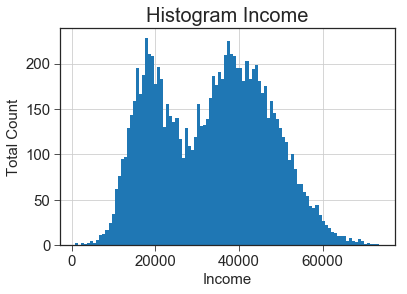

In [19]:
i_ax = cc_data.income.hist(bins=100)
i_ax.set_title('Histogram Income')
i_ax.title.set_size(20)
i_ax.tick_params(labelsize=15)
i_ax.set_ylabel('Total Count', size=15)
t = i_ax.set_xlabel('Income', size=15)

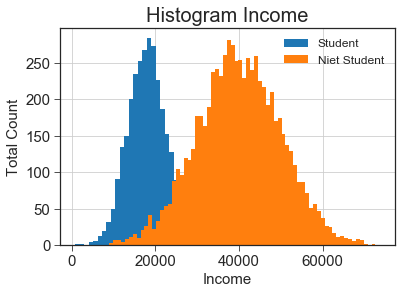

In [20]:
i_ax = cc_data[cc_data.student == 'Yes'].income.hist(bins=30, label='Student')
i_ax = cc_data[cc_data.student == 'No'].income.hist(bins=70, label='Niet Student')
i_ax.set_title('Histogram Income')
i_ax.title.set_size(20)
i_ax.tick_params(labelsize=15)
i_ax.set_ylabel('Total Count', size=15)
t = i_ax.set_xlabel('Income', size=15)
t = i_ax.legend(fontsize=12)

# CRISP-DM -- Modeling - 25% Time
## Creating Classification Model

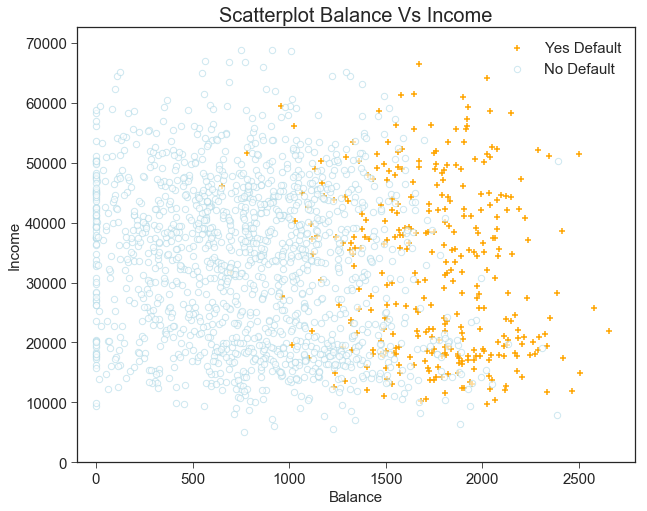

In [21]:
# Take a fraction of the samples where target value (default) is 'no'
df_no = cc_data[cc_data.default_encoded == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = cc_data[cc_data.default_encoded == 1]
df_ = df_no.append(df_yes)

plt.figure(figsize=(10,8))
plt.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1, label='Yes Default')
plt.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6, label='No Default')

plt.gca().set_title('Scatterplot Balance Vs Income')
plt.gca().title.set_size(20)
plt.gca().set_ylim(ymin=0)
plt.gca().set_ylabel('Income', size=15)
plt.gca().set_xlim(xmin=-100)
plt.gca().set_xlabel('Balance', size=15)
plt.gca().tick_params(labelsize=15)
t = plt.legend(fontsize = 15)

In [22]:
X = cc_data.loc[:,['student_encoded','balance_scaled','income_scaled','balance_lt_1_eur']]
y = cc_data.default_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Logistic Regression

In [23]:
clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
lgr_lbl_coefs = pd.DataFrame(list(zip(['student_encoded','balance_scaled','income_scaled','balance_lt_1_eur']
                                      , clf.coef_.tolist()[0], np.abs(clf.coef_).tolist()[0]))
                            , columns=['label','coef','abs(coef)'])

lgr_lbl_coefs.sort_values('abs(coef)', ascending=False)

,label,coef,abs(coef)
1,balance_scaled,10.858869,10.858869
0,student_encoded,-0.331703,0.331703
2,income_scaled,-0.113346,0.113346
3,balance_lt_1_eur,-0.066126,0.066126


### Extreme Gradient Boosted Trees

In [25]:
xclas = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, min_samples_leaf=10) 
xclas.fit(X_train, y_train)  

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, min_samples_leaf=10, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

Text(0.5,0,'F score')

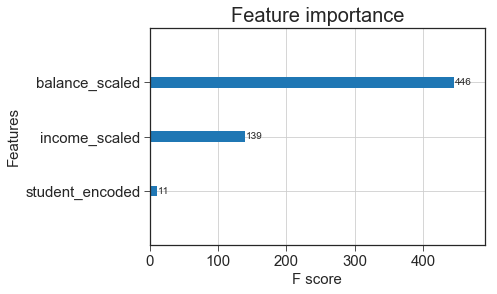

In [26]:
t = plot_importance(xclas)
plt.gca().title.set_size(20)
plt.gca().tick_params(labelsize=15)
plt.gca().set_ylabel('Features', size=15)
plt.gca().set_xlabel('F score', size=15)

# CRISP-DM -- Evaluation - 15% Time

In [27]:
# Plot the confusion matrix corresponding to a model
def plot_confusion_matrix(y_label, y_pred, model_name, xlabels, ylabels, ax
                          , column=None, additional_file_label='', save=True):
    matrix = confusion_matrix(y_label, y_pred)
    plot_confusion_matrix_directly(matrix, model_name, xlabels, ylabels, ax=ax
                                   , column=column, additional_file_label=additional_file_label,
                                   save=save)


# Plot a given confusion matrix
def plot_confusion_matrix_directly(matrix, model_name, xlabels, ylabels, ax
                                   , column=None, additional_file_label='', save=True):
    conf_perc = 100.0 * matrix / sum(sum(matrix))
    conf_text = pd.DataFrame(matrix.astype(str)) + '\n' + np.round(conf_perc,
                                                                   2).astype(str) + '%'
    if column:
        plt.title('Confusion Matrix (' + column + ', ' + model_name + ')',
                  fontsize=14, y=1.03)
    else:
        ax.set_title('Confusion Matrix (' + model_name + ')', fontsize=14, y=1.03)

    ax = sns.heatmap(
        matrix, annot=conf_text, fmt="s", cmap="YlGnBu", cbar=False, ax=ax
        , annot_kws={'size': 20, 'linespacing': 1.5})
    ax.set_xticklabels(xlabels, ha='center', fontsize=14)
    ax.set_yticklabels(ylabels, va='center', fontsize=14)
    if save:
        if column:
            filename = 'confusion_matrix_' + model_name.replace(' ',
                                                                '_') + '_' + column + additional_file_label \
                       + IMG_EXT
        else:
            filename = 'confusion_matrix_' + model_name.replace(' ',
                                                                '_') + additional_file_label + IMG_EXT
        plt.savefig(os.path.join(IMGDIR, filename), bbox_inches='tight')
        
# Plot confusion costs 
def plot_confusion_costs_directly(matrix, model_name, xlabels, ylabels, column=None, additional_file_label='', save=True):
    conf_text = pd.DataFrame(matrix.astype(str)) 
    plt.figure(figsize=(8, 8))
    
    if column:
        plt.title('Confusion Matrix (' + column + ', ' + model_name + ')',
                  fontsize=14, y=1.03)
    else:
        plt.title('Confusion Matrix (' + model_name + ')', fontsize=14, y=1.03)

    ax = sns.heatmap(matrix, annot=conf_text, fmt="s", cmap="YlGnBu", cbar=False
                , annot_kws={'size': 20, 'linespacing': 1.5})
    ax.set_xticklabels(xlabels, ha='center', fontsize=14)
    ax.set_yticklabels(ylabels, va='center', fontsize=14)
    if save:
        if column:
            filename = 'confusion_matrix_' + model_name.replace(' ',
                                                                '_') + '_' + column + additional_file_label \
                       + IMG_EXT
        else:
            filename = 'confusion_matrix_' + model_name.replace(' ',
                                                                '_') + additional_file_label + IMG_EXT
        plt.savefig(os.path.join(IMGDIR, filename), bbox_inches='tight')

In [28]:
pd.DataFrame(y_test.value_counts())

,default_encoded
0,3865
1,135


In [29]:
pproba_lgr_train = pd.DataFrame(clf.predict_proba(X_train))
pproba_xg_train = pd.DataFrame(xclas.predict_proba(X_train))

def compute_clf_tresh(pproba_df, y_t):
    threshold_list = [0.01, 0.02, 0.03, 0.04, 0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    y_df_scores = pd.DataFrame([], columns=['sensitivity','precision' 
                                            ,'specificity','avg_costs','tt_costs'])
    for i in threshold_list:
        y_df_pred_t = pproba_df.iloc[:,1].apply(lambda x: 1 if x>i else 0)
        tn, fp, fn, tp = confusion_matrix(y_t, y_df_pred_t).ravel()
        ttl = tn + fp + fn + tp
        y_df_scores.at[i,'sensitivity'] = sensitivity = recall_score(y_t, y_df_pred_t)
        y_df_scores.at[i,'precision'] = precision = precision_score(y_t, y_df_pred_t)
        y_df_scores.at[i,'specificity'] = specificity = tn / (tn+fp)
        y_df_scores.at[i,'avg_costs'] = 785 * (tp/ttl) - 50 * (fp/ttl) + 0 * (fn/ttl) + 0 * (tn/ttl)
        y_df_scores.at[i,'tt_costs'] = 785 * tp - 50 * fp + 0 * fn + 0 * tn
    return y_df_scores
        
y_lgr_scores = compute_clf_tresh(pproba_lgr_train, y_train)
y_xg_scores = compute_clf_tresh(pproba_xg_train, y_train)

/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Nx/anaconda/e

In [30]:
# y_lgr_scores.sort_values('avg_costs', ascending=False)
# y_xg_scores.sort_values('avg_costs', ascending=False)

In [31]:
# plot_confusion_costs_directly(np.array([[0,-50],[0,835-50]]), 'Costs', ['Predicted_No_Default','Predicted_Yes_Default']
#                                , ['True_No_Default','True_Yes_Default'], save=False)

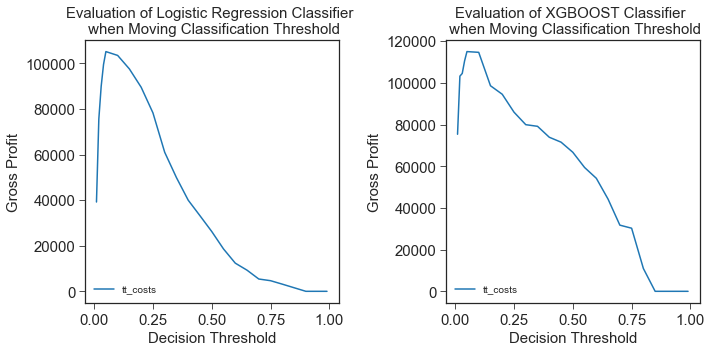

In [32]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
t = y_lgr_scores['tt_costs'].plot(ax = axes[0])
t.set_ylabel('Gross Profit', size=15)
t.set_xlabel('Decision Threshold', size=15)
tt = t.set_title('Evaluation of Logistic Regression Classifier \n when Moving Classification Threshold').set_size(15)
t.tick_params(labelsize=15)
tt = t.legend(loc='lower left')
t = y_xg_scores['tt_costs'].plot(ax = axes[1])
tt = t.set_title('Evaluation of XGBOOST Classifier \n when Moving Classification Threshold').set_size(15)
t.tick_params(labelsize=15)
t.set_ylabel('Gross Profit', size=15)
t.set_xlabel('Decision Threshold', size=15)
tt = t.legend(loc='lower left')
plt.tight_layout()

In [33]:
pproba_lgr_test = pd.DataFrame(clf.predict_proba(X_test))
pproba_xg_test = pd.DataFrame(xclas.predict_proba(X_test))
y_lgr_pred_test = pproba_lgr_test.iloc[:,1].apply(lambda x: 1 if x> 0.05 else 0)
y_xg_pred_test = pproba_xg_test.iloc[:,1].apply(lambda x: 1 if x> 0.05 else 0)

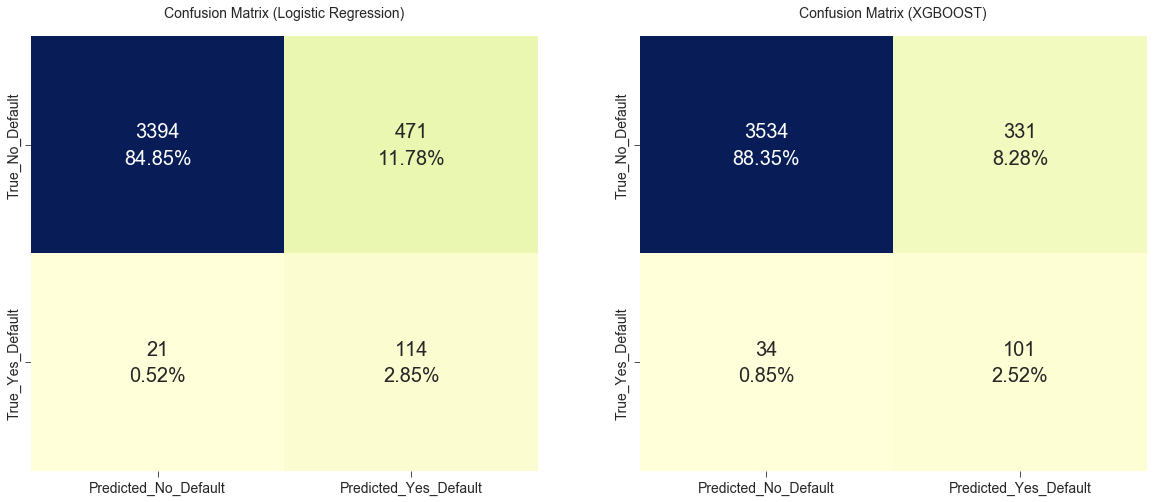

In [34]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
plot_confusion_matrix(y_test, y_lgr_pred_test, 'Logistic Regression', ['Predicted_No_Default','Predicted_Yes_Default']
                      , ['True_No_Default','True_Yes_Default'], ax=axes[0], save=False)
plot_confusion_matrix(y_test, y_xg_pred_test, 'XGBOOST', ['Predicted_No_Default','Predicted_Yes_Default']
                      , ['True_No_Default','True_Yes_Default'], ax=axes[1], save=False)

In [35]:
# print(f1_score(y_test, y_lgr_pred_test), precision_score(y_test, y_lgr_pred))
# print(f1_score(y_test, y_xg_pred_test), precision_score(y_test, y_xg_pred))

# CRISP-DM -- Deployment
We describe this further through the funnel.